## ASSIGNMENT-1

Student IDs: 

2023900021

2022201039

Names: 

Hrithik Sagar

Subhadeep 


### Instructions
 * Fill in the student ID and name of the team members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to a straight zero.
 * Write a report that briefly describes your approach/algorithm used, your final results and any other findings.
 * Add any report, graphs, plots and other results files under the results folder.
 * Submit a zip containing this notebook and results folder on Moodle as <team_name\>.zip. 
 * The deadline is **Feb 7th, 23:55**. This is a hard deadline, and no submissions will be accepted after this.

### SECTION 1: Rapidly-exploring Random Tree (RRT)

Welcome to the first assignment of the course! You are living on the desert planet of Tatooine, and you
have been tasked with building a robot for the Resistance. You have already put together all the circuits,
but you still have to solve the robotic path planning problem. You need to help the robot navigate from
its initial location to its destination, whilst efficiently avoiding stormtrooper obstacles on the way.

The goal of this assignment is to implement the RRT path planning algorithm for a robot. Do not use inbuilt function for RRT. 

The robot is to navigate a two-dimensional space, avoiding known locations with obstacles and travelling from its initial location to a goal location. Given localization information (robot’s initial position, obstacle location, goal location), your task is to implement a path-planning decision-maker to drive the robot from its initial position to the desired location.

Specifically, the problem can be formed as follows: Consider a 2D grid instantiated with different kinds of obstacles (for instance, geometrical shapes like Rectangles, Circles, Triangles or a combination of any of the above 2/3). You are given a start and end point on this grid. You must implement the RRT algorithm for two cases: 
1. Holonomic Robot      - moves in any direction
2. Non-Holonomic Robot. - moves forward, backward, sides

You must submit two videos for each of the above cases, showing the evolution of your graphs. The first one should showcase only the platform centre velocity, that is the trajectory of the center of the robot. Something like this:

<img src="misc/1.png" alt="image 1" width="300"/>

Your second video should show the individual wheel trajectories (evolution of all the wheels in all the possible paths). Ensure that no collisions happen near the boundaries and use methods explained in the class for this. Also, the trajectories for each individual wheel must appear consistent. The left wheel should not go haywire while the right wheel’s trajectory is smooth - they must be in sync with one another. If you code the algorithm right, the kinematics will guarantee this! :)

You can refer to this [video](https://robotics.iiit.ac.in/videos/Quasistatic/eathakota_etal_iros11.mp4), which shows the trajectories plotted for all three wheels of the robot. Although this is done in 3D, and you need to implement this for only two dimensions. Your plot should look like below.

<img src="misc/2.png" alt="image 1" width="300"/>

Hence, there will be 4 videos in total: 2 for holonomic and 2 more for non-holonomic. For each case, one video will show the platform centre velocity and the other, the individual wheel trajectories. You should save all the graphs, combine them into a video, save them in the results folder, and include them in your report if necessary. You should also include a few pictures of the plots in your report, along with the video links. Use the given helper function to generate video from individual frames.

Deliverables:
* Code for both cases. Please ensure the code is well written, and we can ask you to explain certain snippets of it during evaluations.
* Two graphs, as explained above, for each case.
* A report summarizing your understanding of the algorithm and an explanation of the results.

You have been a helper function to generate the video from frames (make_video.py). Also the environment has been created for you. 

Feel free to reach out to TAs for any queries. All the best!

In [1]:
# List the imports here
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from matplotlib.lines import Line2D
import itertools

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
class env:
    def __init__(self, x_start, y_start, x_goal, y_goal, rbot, xmin=0, xmax=100, ymin=0, ymax=100):
        self.x_start, self.y_start, self.x_goal, self.y_goal = x_start, y_start, x_goal, y_goal
        self.xlim = (xmin, xmax)
        self.ylim = (ymin, ymax)
        self.rbot = rbot
        self.obstacles()
        
    def obstacles(self):
        # Specify vertices for rectangular obstacles (each object has four vertices).
        v_origx= [40,40,60,60,70,70,80,80,40,40,60,60]
        v_origy= [62,100,100,62,40,60,60,40,0,38,38,0]
        vx = [i for i in v_origx]
        vy = [i for i in v_origy]
        # Centers and radii of the circular obstacles.
        radii = [7, 2, 3]
        circle_x = [20,90,77]
        circle_y = [20,70,82]
        num_circles = len(circle_x)

        self.num_rectangles = 3
        self.obst_x = vx
        self.obst_y = vy
        self.radii = radii
        self.circle_x = circle_x
        self.circle_y = circle_y
        self.num_circles = num_circles
        
    def draw(self):
        #draw boundary
        rbot = self.rbot
        plt.plot([0-2*rbot, 0-2*rbot, 100+2*rbot, 100+2*rbot, 0-2*rbot],
                 [0-2*rbot, 100+2*rbot, 100+2*rbot, 0-2*rbot, 0-2*rbot],'k', lw=0.5)
    
        plt.plot(self.x_goal, self.y_goal , 'g*', markersize = 20)
        plt.plot(self.x_start, self.y_start, 'b*', markersize = 20)
    
        num = len(self.obst_x)/4
        for i in range(1,int(num)+1): # Plotting rectangles
            x = self.obst_x[4*(i-1)]
            y = self.obst_y[4*(i-1)]
            width = self.obst_x[4*(i-1)+2] - self.obst_x[4*(i-1)]
            height = self.obst_y[4*(i-1)+2] - self.obst_y[4*(i-1)]
            rect = plt.Rectangle((x,y), width, height, linewidth=1, color='r')
            plt.gca().add_patch(rect)
    
        for i in range(self.num_circles): #plotting  circles
            circle = plt.Circle((self.circle_x[i], self.circle_y[i]), self.radii[i], color='r')
            plt.gca().add_patch(circle)
    
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

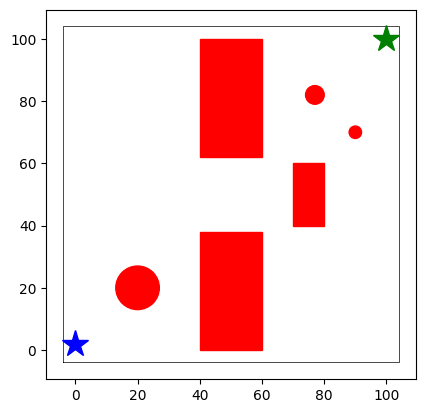

In [3]:
# Goal and start location region
x_sart, y_start, x_goal, y_goal = 0, 2, 100, 100 
# Radius of the robot
r_bot = 2
# Environment instance
E = env(x_sart, y_start, x_goal, y_goal, r_bot, 0, 100, 0, 100) 
E.draw()